In [7]:
import numpy as np
import pandas as pd
import requests
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Define new column names
new_column_names = ['date','open','high','low','close','adj_close','volume','dividend_amount','split_coeff']

# Read the CSV file with new column names
df = pd.read_csv('AAPL_daily_adjusted.csv', header=0, names=new_column_names)

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df = df.set_index('date')

# Adding indicators
df['RSI'] = ta.rsi(df.close, length=15)
df['EMAF'] = ta.ema(df.close, length=20) #Fast MA
df['EMAM'] = ta.ema(df.close, length=100) #Medium MA
df['EMAS'] = ta.ema(df.close, length=150) #Slow MA

df['target'] = df['adj_close'].shift(1)

df.dropna(inplace=True)
df.drop(['dividend_amount', 'split_coeff'], axis=1, inplace=True)

df.head()

,open,high,low,close,adj_close,volume,RSI,EMAF,EMAM,EMAS,target
date,,,,,,,,,,,
2022-09-28,147.64,150.6414,144.840,149.84,149.363873,146691387.0,56.669027,143.795304,146.639672,148.156933,142.027260
2022-09-27,152.74,154.7200,149.945,151.76,151.277772,84442741.0,58.464396,144.553846,146.741065,148.204656,149.363873
2022-09-26,149.66,153.7701,149.640,150.77,150.290918,93339409.0,57.156073,145.145861,146.820845,148.238634,151.277772
2022-09-23,151.19,151.4700,148.560,150.43,149.951998,96029909.0,56.689273,145.649112,146.892314,148.267659,150.290918
2022-09-22,152.38,154.4700,150.910,152.74,152.254658,86264792.0,59.119683,146.324435,147.008110,148.326895,149.951998


# Preprocessing

In [9]:
# Use data to 2017 for training, 2018 to 2020 for validation, and 2021 to 2023 for testing
train_df = df[: '2017-12-31']
val_df = df['2018-01-01' : '2020-12-31']
test_df = df['2021-01-01':]

def create_dataset(X, y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back-1):
        a = X[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(y[i + look_back])
    return np.array(dataX), np.array(dataY)

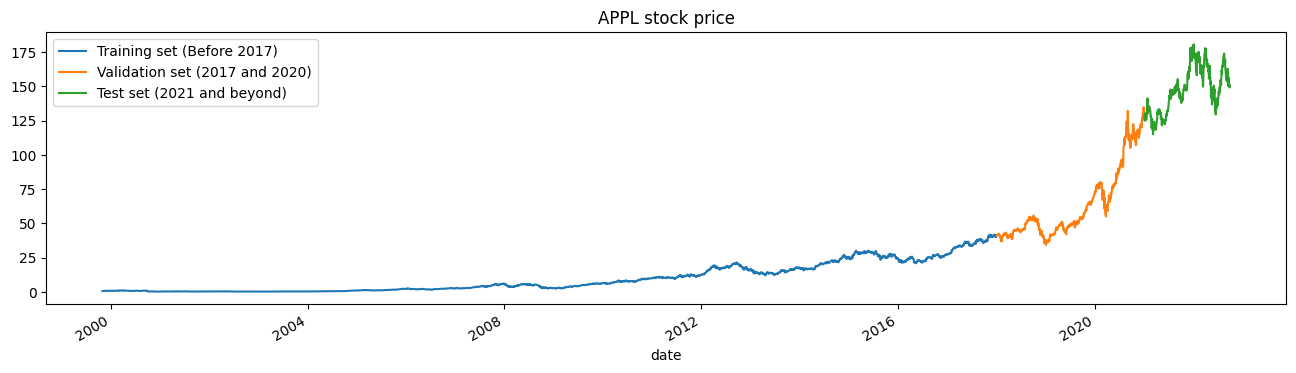

In [10]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
train_df['adj_close'].plot(figsize=(16,4),legend=True)
val_df['adj_close'].plot(figsize=(16,4),legend=True)
test_df['adj_close'].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Validation set (2017 and 2020)', 'Test set (2021 and beyond)'])
plt.title('APPL stock price')
plt.show()

In [11]:
features = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'RSI', 'EMAF', 'EMAM', 'EMAS']
target = 'target'

# Apply scaling to features only
sc = MinMaxScaler(feature_range=(0,1))

# Constants
LOOK_BACK = 60

X_train = sc.fit_transform(train_df[features])
y_train = train_df[target].to_numpy()

X_val = sc.transform(val_df[features])
y_val = val_df[target].to_numpy()

X_test = sc.transform(test_df[features])
y_test = test_df[target].to_numpy()

# Create datasets for training, validation, and testing
X_train, y_train = create_dataset(X_train, y_train, LOOK_BACK)
X_val, y_val = create_dataset(X_val, y_val, LOOK_BACK)
X_test, y_test = create_dataset(X_test, y_test, LOOK_BACK)

In [12]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')

print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (4510, 60, 10)
y_train: (4510,)
X_val: (695, 60, 10)
y_val: (695,)
X_test: (377, 60, 10)
y_test: (377,)


## Modeling 1

In [13]:
# Define the LSTM model
model = Sequential()

# Add the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

# Add a Dense layer
model.add(Dense(units = 25))

# Output layer
model.add(Dense(units = 1))

# Compile and fit the model on 30 epochs
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=15, epochs=50, validation_data=(X_val, y_val))

2023-05-18 17:22:24.857936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-18 17:22:24.858247: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 17:22:24.858343: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dapo-Laptop): /proc/driver/nvidia/version does not exist
2023-05-18 17:22:24.859342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
301/301 [==============================] - 15s 40ms/step - loss: 23.8463 - val_loss: 1374.3463
Epoch 2/50
301/301 [==============================] - 12s 39ms/step - loss: 2.8603 - val_loss: 985.1337
Epoch 3/50
301/301 [==============================] - 11s 38ms/step - loss: 1.8524 - val_loss: 885.7316
Epoch 4/50
301/301 [==============================] - 11s 38ms/step - loss: 1.5251 - val_loss: 863.8376
Epoch 5/50
301/301 [==============================] - 11s 38ms/step - loss: 1.6634 - val_loss: 877.0578
Epoch 6/50
301/301 [==============================] - 11s 38ms/step - loss: 1.5081 - val_loss: 852.7739
Epoch 7/50
301/301 [==============================] - 12s 39ms/step - loss: 1.5306 - val_loss: 766.7181
Epoch 8/50
301/301 [==============================] - 12s 41ms/step - loss: 1.4483 - val_loss: 755.8849
Epoch 9/50
301/301 [==============================] - 12s 40ms/step - loss: 1.3392 - val_loss: 757.6879
Epoch 10/50
301/301 [==============================] - 12s 39m

In [14]:
# Getting the predicted stock price
y_pred = model.predict(X_test)

# Calculate and print some evaluation metric (e.g., MSE)
print(mean_squared_error(y_test, y_pred))

12/12 [==============================] - 1s 17ms/step
8440.85782209995
